# Ordinary Differential Equations

This notebook shows simplified approaches to solve ordinary differential equations with given initial conditions. 
First, we start by giving an example (extracted from the book of Chapra \cite{chapra2012AppliedNumericalMethods}) and then we present the Euler method as a first solution approach. Later we present the Runge-Kutta method of fourth order, and finally how to solve general systems. The idea is to compare those methods and be able to quantitatively choose one over other (although, at the end, the advice is to use the `scipy` tools).

In general, what we want to solve is the ordinary differential equation  of first-order of the form
$$\frac{dy}{dt} = f(t, y),$$
where $y$ represents, for instance, the system state, and $f(y, t)$ is the function that describes the change in time and, in general, depends both on the current system state and the time.


## Example
Going back again to the Bungee-jumping problem, now you want to model the force or acceleration of the jumper at any moment. If the cord is stretched, it exerts an upward force on the jumper, while the viscous damping with the air is always opposing the movement, so the sign of the velocity must be taken into account. This generates the following differential equation,
$$\frac{dv}{dt} = g - \textrm{sign}(v)\frac{c_d}{m}v^2 - \frac{k}{m}(x-L) - \frac{\gamma}{m}, $$
where $\textrm{sign}$ is the sign function, $x-L$ the elongation of the cord, $k$ its elastic constant, and $\gamma$ the viscous damping coefficient of the cord itself.  This is a non-linear differential equation and solving it in closed form might be impossible, so we need to use some numerical method. Furthermore, if you need to obtain the position, you will need to also solve 
$$\frac{dx}{dt} = v,$$
which complements the previous equation and actually generates a system of differential equations, something we will talk more later.

# Euler method
Let's take equation (1) and check that the derivative can be approximated as
$$\frac{dy}{dt} = f(t, y) = \frac{y(t+\delta t) - y(t)}{\delta t} ,$$
for a sufficiently small time step $\delta t$ . If you discretize the time in steps of size $\delta t$, you can identify the time $t + \delta t$ as the next time after time $t$, so you can write the next value for $y$ in terms of the current one as
$$y(t+\delta t) = y(t) + \delta t f(y, t) +O(\delta t^2) .$$
This is the so-called **Euler Method**, and you can interpret it as constructing a straight line between the two points. See the next figure, from Chapra. The local error is of order $\delta t^2$ because we are ignoring first that term in the series expansion of $y(t+\delta t)$.  

<img src="fig/euler-01.png">

## Example for the Euler Method
Following Chapra, let's solve the following ordinary differential equation by means of the Euler method,
$$\frac{dy}{dt} = 4e^{0.8t} - 0.5y,$$
whose solution is 
$$y = \frac{4}{1.3}(e^{0.8t} - e^{-0.5t}) + 2e^{-0.5t}.$$
Let's solve it from $t =0$ to $t=4$ in steps $\delta t = 1$. The initial condition is $y=2$ when $t=0$. Your task is to use the Euler method to solve the differential equation and to compare with the theoretical solution. 

To do so, please first create a function called `euler` that receives a vector of time steps and returns the numerical solution. You will also need to define a function, called `fderiv`, that returns the derivate of the function and receives the time and the current value of $y$. Once those functions are defined defined, use them to plot the numerical and the theoretical solution. 


In [9]:
import numpy as np

def fderiv(y, t):
    return 4*np.exp(0.8*t) - 0.5*y

def euler(t, y0, dt):
    """
    This function computes the solution of an ODE using the Euler method.
    INPUT:
    t  = numpy array of time steps
    y0 = float, initial condition
    dt = time steps
    RETURNS:
    y = Array of len(t) with the solution
    """
    y = np.zeros_like(t) # creates the array to save the solution
    y[0] = y0 # save the initial condition
    for ii in range(1, len(t)) :
        tstep = t[ii-1]
        y[ii] = y[ii-1] + fderiv(y[ii-1], tstep)*dt
    return y

<IPython.core.display.Javascript object>


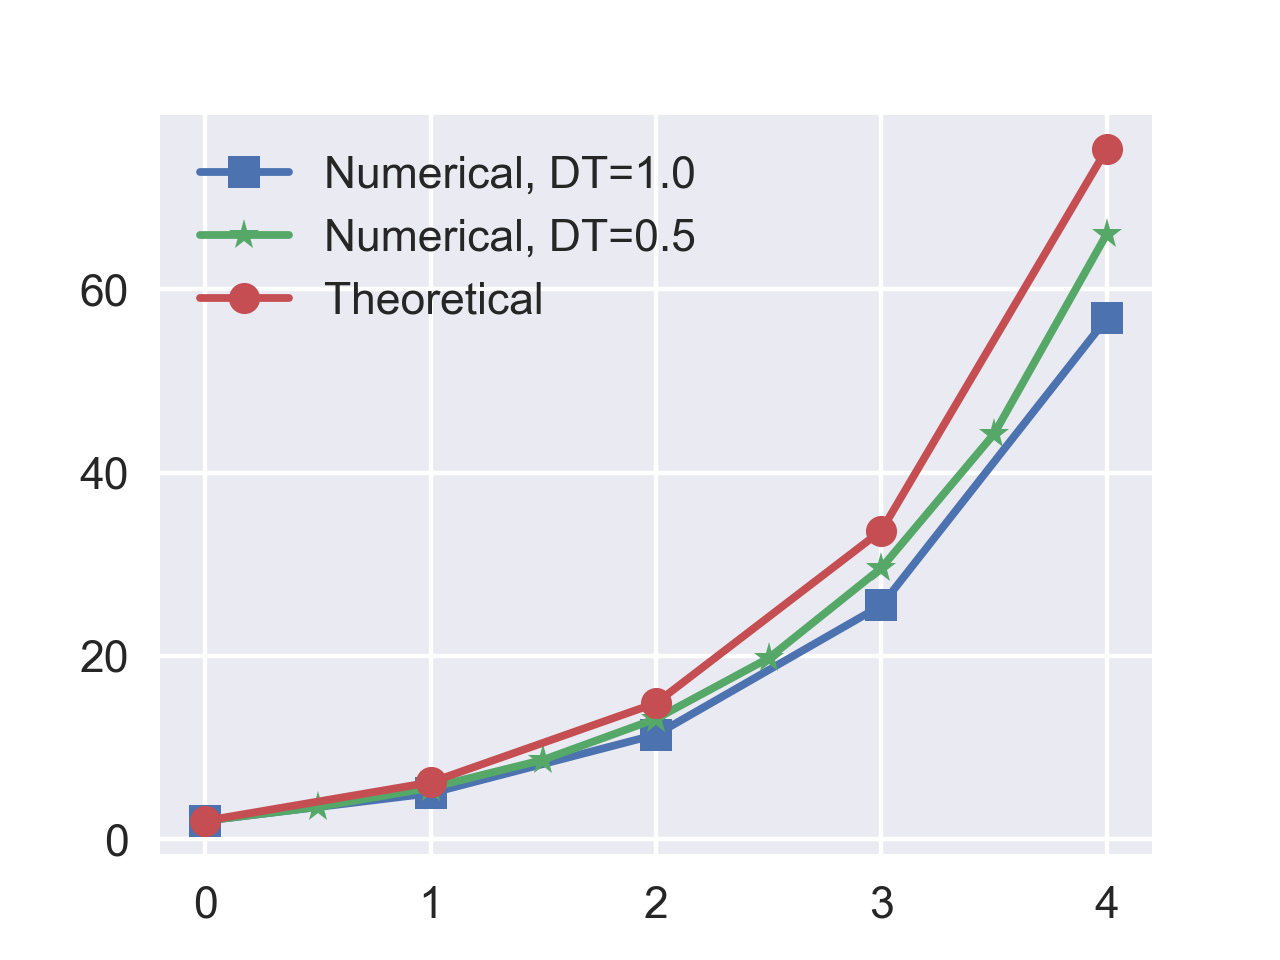

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("poster")

DT = 1.0
Y0 = 2.0
t = np.arange(0.0, 4+DT, DT)
y = euler(t, Y0, DT)
t2 = np.arange(0.0, 4+DT/2, DT/2)
y2 = euler(t2, Y0, DT/2)

fig, ax = plt.subplots()
ax.plot(t, y, '-s', label="Numerical, DT=1.0")
ax.plot(t2, y2, '-*', label="Numerical, DT=0.5")
ax.plot(t, 4*(np.exp(0.8*t) - np.exp(-0.5*t))/1.3 + 2*np.exp(-0.5*t), '-o', label="Theoretical")
ax.legend()

As you can see here, the Euler method is close but is not so good and it is necessary to decrease the time step to get less error.  The next example will estimate the error at the end as a function of the time step $\delta t$ .

## Computing the error for the Euler method
Plot the percent error at the last time step as a function of the size of $\delta t$. This allows you to check the order of convergence of the algorithm. Does it look linear?

<IPython.core.display.Javascript object>


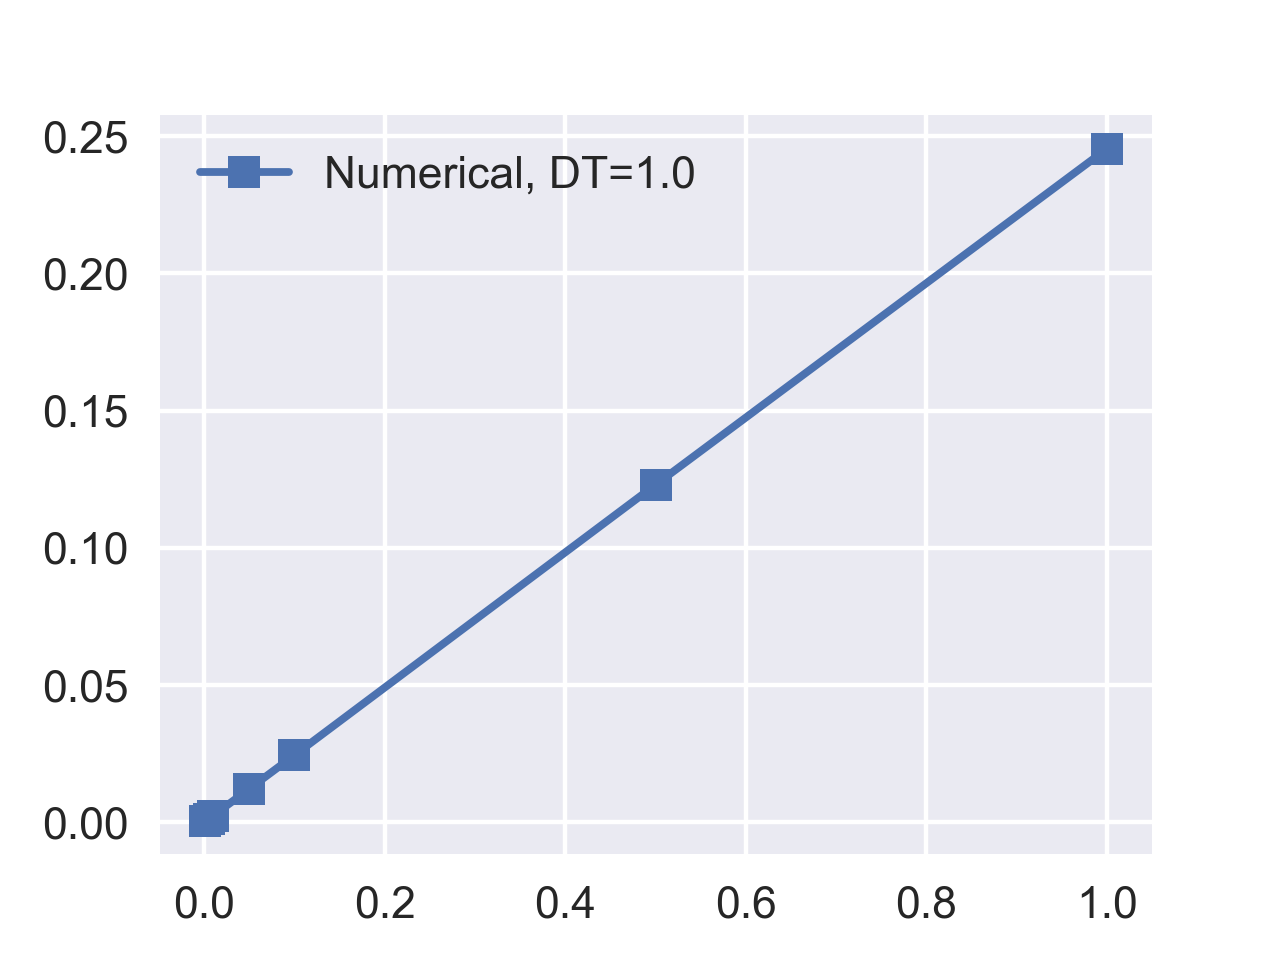

In [29]:
DTLIST=np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
ylast = np.zeros_like(DTLIST)
for istep, DT in enumerate(DTLIST):
    t = np.arange(0.0, 4+DT, DT)
    y = euler(t, Y0, DT)
    ylast[istep] = y[-1] # save the last one

YLASTTHEO=4*(np.exp(0.8*4) - np.exp(-0.5*4))/1.3 + 2*np.exp(-0.5*4)
fig, ax = plt.subplots()
ax.plot(DTLIST, np.abs((ylast - YLASTTHEO)/YLASTTHEO), '-s', label="Numerical, DT=1.0")
ax.legend()


From here you can see that the error decreases linearly with the time step, which verifies the order of the algorithm. The simplicity of the Euler methods comes with a small order for the error. There are more elaborate methods whose error decreases faster, at the expense of being more complex to implement, like the Runge-Kutta method.

### Exercise: Compute the minimum $\delta t$ to have an error of $10^{-5}$
Con you do it automatically instead of manually?

# Stability of the Euler method
It is possible that for some ODE the Euler method is conditionally stable. This means that its convergence to the true solution depend on the time step. For instance, let's take the following ODE,
$$\frac{dy}{dt} = -ay,$$
with $a>0$ and whose solution for $y(0) = y_0$ is 
$$y(t) = y_0 e^{-at}.$$
If we use the Euler method to solve this numerically, we have to replace the derivative into
$$y_{i+1} = y_i + \frac{dy_i}{dt} \delta t, $$
so we obtain
$$y_{i+1} = y_i(1-a\delta t).$$
The quantity $y_{i+1}/y_i$ is called the amplification factor and if it is larger than one then the solution will blown up. To avoid so, we need 
$$\left|\frac{y_{i+1}}{y_i}\right| = |(1-a\delta t)| < 1,$$
so, for this example,  
$$0 < \delta t< \frac{2}{a}.$$
All of these mean that the Euler method is conditionally stable for the example ODE we used. 

## Exercise
Given $a = 2.7$, solve the previous ODE using the Euler method with two timesteps: $\delta t = 0.73$ and $0.75$. Which one should be stable? solve for $t \in [0, 10]$ and $y_0 = 3.43$.  

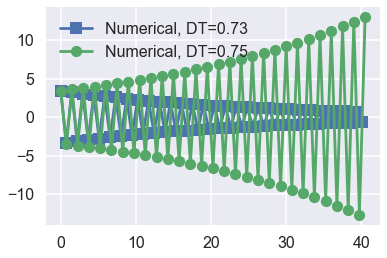

In [51]:
%matplotlib inline
A = 2.7
def fderiv(y, t):
    return -A*y

TF=40
DT1 = 0.73
DT2 = 0.75
Y0 = 3.43
t1 = np.arange(0.0, TF+DT1, DT1)
t2 = np.arange(0.0, TF+DT2, DT2)
y1 = euler(t1, Y0, DT1)
y2 = euler(t2, Y0, DT2)

fig, ax = plt.subplots()
ax.plot(t1, y1, '-s', label="Numerical, DT={:.2f}".format(DT1))
ax.plot(t2, y2, '-o', label="Numerical, DT={:.2f}".format(DT2))
ax.legend()

# Ejercicios (See Chapra Chapter 22)

1. (22.1) Solve the following initial value problem over the interval from $t=0$ to $t=2$ where $y(0)=1$. Display all your results on the same graph.
$$
\frac{dy}{dt} = yt^3-1.5
$$
a. Analytically.
b. Using Euler's method with $h = 0.5$ and $h=0.25$.

2. (22.6) Suppose that a projectile is launched upward from the earth's surface. Assume that the only force acting on the object is the downward force of gravity. Under these conditions, a force balance can be used to derive
$$
\frac{dv}{dt} = -g(0)\frac{R^2}{(R+x)^2},
$$
where $v =$ upward velocity (m/s), $t =$ time (s), $x =$ altitude (m) measured upward from the earth’s surface, $g(0) =$ the gravitational acceleration at the earth’s surface ($\simeq 9.81$ m/s$^2$), and $R =$ the earth's radius ($\simeq 6.37\times 10^6$ m). Recognizing that $dx/dt = v$, use Euler's method to determine the maximum height that would be obtained if $v(t = 0) = 1500$ m/s.

# References

(<a id="cit-chapra2012AppliedNumericalMethods" href="#call-chapra2012AppliedNumericalMethods">Chapra, 2012</a>) Steven C Chapra, ``_Applied Numerical Methods with MATLAB for Engineers and Scientists._'',  2012.

